In [2]:
%matplotlib inline

In [38]:
import pandas as pd
import requests
import io

# Download USDA data

In [4]:
cols = ['WTEQ', 'SNWD', 'PREC', 'TOBS',] # 'TMAX', 'TMIN', 'TAVG']
# water equivalent, snow depth, precipitation, observed temperature,

In [5]:
colstring = ','.join('{}::value'.format(name) for name in cols)
colstring

'WTEQ::value,SNWD::value,PREC::value,TOBS::value'

In [6]:
fmt = ('http://wcc.sc.egov.usda.gov/reportGenerator/view_csv/'
       'customSingleStationReport/hourly/651:OR:SNTL/{start},{end}/{columns}')

In [7]:
url = fmt.format(start='2014-12-31', end='2015-01-31', columns=colstring)
url

'http://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customSingleStationReport/hourly/651:OR:SNTL/2014-12-31,2015-01-31/WTEQ::value,SNWD::value,PREC::value,TOBS::value'

In [58]:
df = pd.read_csv(io.StringIO(r.text), comment='#')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.head()

,Snow Water Equivalent (in),Snow Depth (in),Precipitation Accumulation (in),Air Temperature Observed (degF)
Date,,,,
2014-12-31 00:00:00,12.1,44,44.6,35
2014-12-31 01:00:00,12.0,45,44.3,28
2014-12-31 02:00:00,12.0,44,44.3,28
2014-12-31 03:00:00,12.0,45,44.3,29
2014-12-31 04:00:00,12.0,44,44.3,29


In [13]:
import matplotlib.pyplot as plt

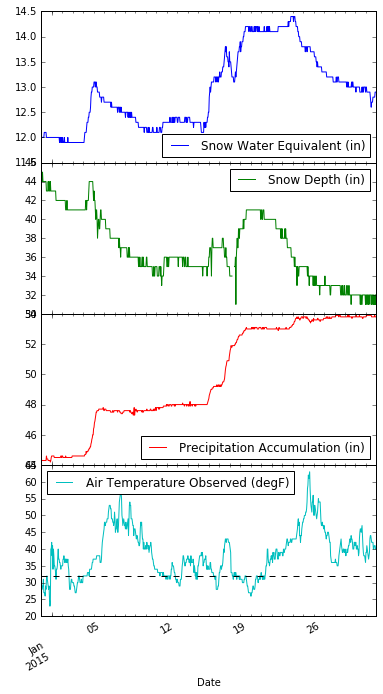

In [59]:
axes = df.plot(subplots=True, figsize=(6,12), legend=True)
plt.subplots_adjust(hspace=0)
axes[-1].axhline(32, c='k', ls='--')

In [ ]:
import matplotlib
matplotlib.__version__

# NWAC ratings comparison

for mt Hood

In [36]:
import sqlalchemy as sa

In [37]:
engine = sa.create_engine('postgres://%s@localhost/%s'%('tkb','avy'))
print(engine.url)

postgres://tkb@localhost/avy


In [62]:
df2 = pd.read_sql_query(r"""
select * from reports 
where reports.region like 'Mt Hood'
and datetime_utc >='2015-01-01'
and datetime_utc <='2015-02-01'
order by datetime_utc
""", engine)
df2.head()

,report_id,datetime,datetime_utc,author,region,summary,treeline_above,treeline_near,treeline_below
0,994,"6:00 PM PST Wednesday, December 31, 2014",2015-01-01 02:00:00,Kenny Kramer,Mt Hood,Recent N-NE winds have created some wind slab ...,Moderate,Moderate,Moderate
1,998,"6:00 PM PST Thursday, January 1, 2015",2015-01-02 02:00:00,Garth Ferber,Mt Hood,Watch for lingering wind slab from early in th...,Moderate,Moderate,Moderate
2,1002,"6:00 PM PST Friday, January 2, 2015",2015-01-03 02:00:00,Garth Ferber,Mt Hood,Watch mainly for lingering local wind slab fro...,Moderate,Moderate,Moderate
3,1006,"5:52 PM PST Saturday, January 3, 2015",2015-01-04 01:52:00,Dennis D'Amico,Mt Hood,The avalanche danger will increase sharply by ...,Considerable,Considerable,Considerable
4,1010,"5:35 PM PST Sunday, January 4, 2015",2015-01-05 01:35:00,Dennis D'Amico,Mt Hood,Dangerous avalanche conditions are expected Su...,Considerable,Considerable,Moderate


In [ ]:
with open('nwac_results_mthood.pickle') as f:
    results = pickle.load(f)

In [ ]:
df2 = pd.DataFrame(results)
df2['utc'] = pd.to_datetime(df2['date'])
df2 = df2.sort_values(by='utc').set_index('utc')
df2

In [63]:
ratings = ['No Rating', 'Low', 'Moderate', 'Considerable', 'High', 'Extreme']

In [66]:
ratdict = {rat:i for i,rat in enumerate(ratings)}

df3 = df2.reset_index().replace({'treeline_above':ratdict,
            'treeline_below':ratdict,
            'treeline_near':ratdict,}
                 ).set_index('datetime_utc')

In [67]:
series = df3['treeline_above'].resample('1H', fill_method='pad')
series.name = 'NWAC Warning level'
dfx = df.join(series, how='inner')

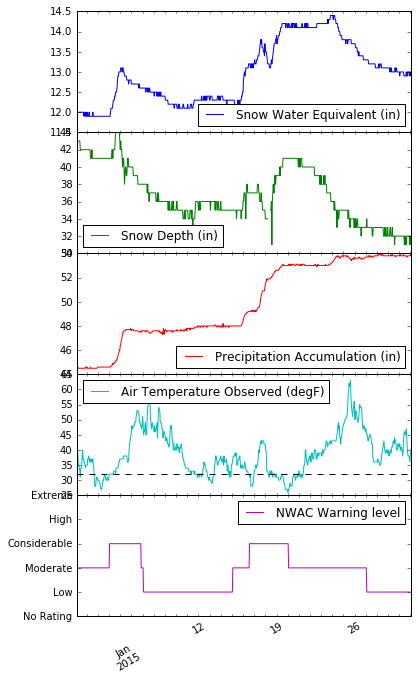

In [70]:
axes = dfx.plot(subplots=True, figsize=(6,12), legend=True)
plt.subplots_adjust(hspace=0)

axes[-2].axhline(32, c='k', ls='--')
axes[-1].set_ylim(-0,5);
axes[-1].set_yticklabels(ratings)
#axes[-1].lines[0].set_marker('o')

#plt.savefig('jan2015.pdf')

# Daily binning

feature engineering: make this into scatter plots

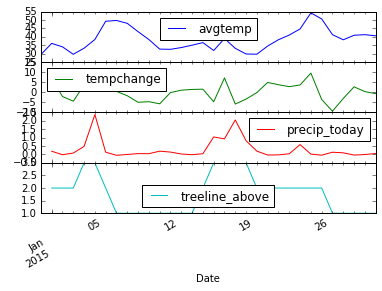

In [126]:
rating_binned = df3['treeline_above'].resample('1D')

precip_binned = df['Precipitation Accumulation (in)'].resample('1D').diff()
precip_binned.name = 'precip_today'

temp_binned = df['Air Temperature Observed (degF)'].resample('1D')
temp_binned.name = 'avgtemp'

dtemp_binned = temp_binned.diff()
dtemp_binned.name = 'tempchange'

engineered = pd.concat([temp_binned, dtemp_binned, precip_binned, rating_binned], axis=1)
engineered.plot(subplots=True)
plt.subplots_adjust(hspace=0)

In [127]:
engineered.columns

Index(['avgtemp', 'tempchange', 'precip_today', 'treeline_above'], dtype='object')

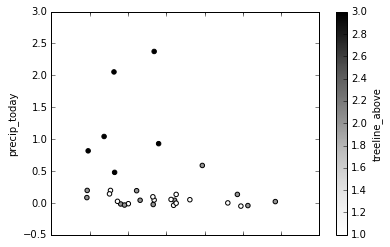

In [128]:
engineered.plot(kind='scatter',
                x='avgtemp',
                y='precip_today',
                c='treeline_above')


In [129]:
ratings = ['No Rating', 'Low', 'Moderate', 'Considerable', 'High', 'Extreme']
colors = ['gray', 'green', 'yellow', 'orange', 'red', 'black']
coldict = {rating:color for rating, color in zip(ratings, colors)}

numdict = {i:color for i, color in enumerate(colors)}
coldict

{'Considerable': 'orange',
 'Extreme': 'black',
 'High': 'red',
 'Low': 'green',
 'Moderate': 'yellow',
 'No Rating': 'gray'}

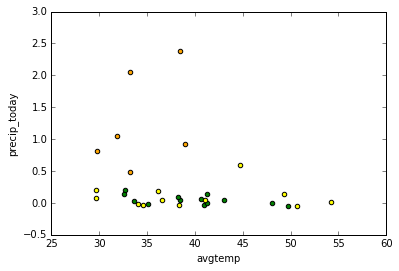

In [132]:
ax = plt.gca()
for val,subdf in engineered.groupby('treeline_above'):
    subdf.plot(kind='scatter',
                x='avgtemp',
                y='precip_today',
                c=numdict.get(val), ax=ax)